In [1]:
from __future__ import annotations

from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torchaudio.models import Conformer

from torch.utils.data import Dataset, DataLoader

import lightning as L

from tqdm import tqdm

import Levenshtein

from vocabulary import VOCABULARY, REVERSE_VOCABULARY, tokens_to_number, number_to_tokens, check_token_seq_possibility

In [2]:
torch.set_float32_matmul_precision('medium')

SAMPLE_RATE = 16000
N_MELS = 80
N_FFT = 256
HOP_LENGTH = 160

DATA_PATH = "../../data/asr-numbers"

In [3]:
class AudioWorker:
    def __init__(self):
        self.mel_transform = T.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
        )

    def load_audio(self, path):
        waveform, sample_rate = torchaudio.load(path)
        waveform = waveform.mean(dim=0, keepdim=True)
        if sample_rate != SAMPLE_RATE:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=SAMPLE_RATE)(waveform)
        return waveform
    
    def apply_augmentations(self, waveform):
        # if np.random.rand() < 0.5:
        #     waveform = T.PitchShift(n_steps=4, sample_rate=SAMPLE_RATE)(waveform)
        if np.random.rand() < 0.5:
            waveform = T.FrequencyMasking(freq_mask_param=40)(waveform)
        if np.random.rand() < 0.5:
            # add noise
            noise = torch.randn_like(waveform) * 0.005
            waveform = waveform + noise
        waveform = T.Vol(gain=np.random.rand()*2)(waveform)
        return waveform
    
    def final_transform(self, waveform):
        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log(mel_spec + 1e-6)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)
        return mel_spec.squeeze(0).transpose(0, 1)
    
audio_worker = AudioWorker()

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


In [4]:
class AudioDataset(Dataset):
    def __init__(self, mode: Literal["train", "dev", "test"]):
        self.mode = mode
        self.info_table = pd.read_csv(f"{DATA_PATH}/{mode}.csv")

        if mode != "test":
            # filter the numbers bellow 1000
            self.info_table = self.info_table[self.info_table["transcription"] >= 1000]
            self.info_table = self.info_table[self.info_table["transcription"] < 1000000]


        self.audio_paths = self.info_table["filename"].tolist()
        self.audios = [
            audio_worker.load_audio(f"{DATA_PATH}/{path}")
            for path in tqdm(self.audio_paths, desc=f"Loading {mode} audios", unit="audio")
        ]

        self.labels = None
        self.transformed_labels = None
        if mode != "test":
            self.labels = self.info_table["transcription"].tolist()
            self.transformed_labels = [
                torch.tensor(number_to_tokens(str(label)))
                for label in tqdm(self.labels, desc=f"Transforming {mode} labels", unit="label")
            ]
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        waveform = self.audios[idx]
        if self.mode == "train":
            waveform = audio_worker.apply_augmentations(waveform)
        mel_spec = audio_worker.final_transform(waveform)
        
        label = self.transformed_labels[idx] if self.transformed_labels is not None else None
        return mel_spec, label
    
def collate_fn(batch):
    mel_specs, labels = zip(*batch)
    mel_specs_lenghts = torch.tensor([mel_spec.shape[0] for mel_spec in mel_specs])
    mel_specs = torch.nn.utils.rnn.pad_sequence(mel_specs, batch_first=True)
    
    if labels[0] is not None:
        labels_lengths = torch.tensor([len(label) for label in labels])
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
        return mel_specs, labels, mel_specs_lenghts, labels_lengths
    else:
        return mel_specs, None, mel_specs_lenghts, None

In [5]:
train_ds = AudioDataset("train")
dev_ds = AudioDataset("dev")
test_ds = AudioDataset("test")

Loading test audios: 100%|██████████| 2582/2582 [00:04<00:00, 568.70audio/s]


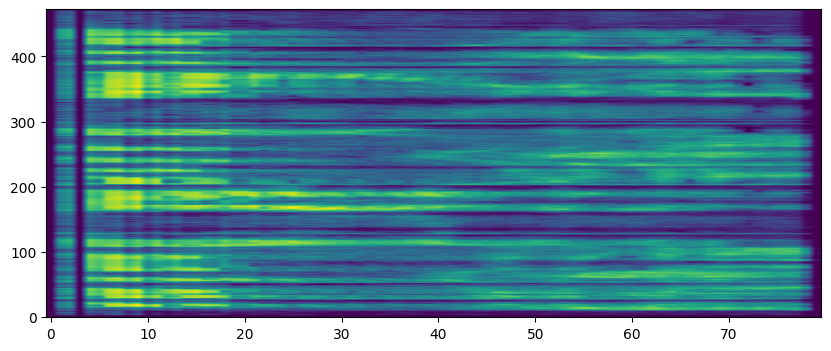

In [6]:
# Draw spectrogram of ad[0][0]
plt.figure(figsize=(10, 4))
plt.imshow(test_ds[0][0].detach().numpy(), aspect="auto", origin="lower")

In [7]:
class LightningModel(L.LightningModule):
    def __init__(self, vocabulary: list[str]):
        super().__init__()
        self.vocabulary = vocabulary

        self.conformer = Conformer(
            input_dim=N_MELS,
            num_heads=16,
            ffn_dim=N_FFT * 4,
            num_layers=12,
            depthwise_conv_kernel_size=7,
        )
        self.fc = nn.Linear(N_MELS, len(vocabulary))

        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)
    
    def forward(self, x, lengths):
        x, lengths = self.conformer(x, lengths)
        x = self.fc(x)
        return x, lengths
    
    def training_step(self, batch):
        mel_spec, labels, mel_spec_lengths, labels_lengths = batch
        logits, lengths = self(mel_spec, mel_spec_lengths)
        
        loss = self.criterion(logits.log_softmax(2).transpose(0, 1), labels, lengths, labels_lengths)

        self.log("train_loss", loss, prog_bar=True)

        self.scheduler.step()
        
        return loss
    
    def validation_step(self, batch):
        mel_spec, labels, mel_spec_lengths, labels_lengths = batch
        logits, lengths = self(mel_spec, mel_spec_lengths)
        logits = logits.log_softmax(2)
        preds = logits.argmax(2)
        
        ld = 0
        for i in range(len(preds)):
            pred = tokens_to_number(preds[i][:lengths[i]])
            label = tokens_to_number(labels[i][:labels_lengths[i]])
            
            ld += Levenshtein.distance(pred, label)
        
        self.log("val_loss", ld / labels.shape[0], prog_bar=True)

        return ld / labels.shape[0]
    
    def configure_optimizers(self):
        return self.optimizer

In [8]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(dev_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    enable_checkpointing=False,
    log_every_n_steps=1000,
)
lightning_model = LightningModel(VOCABULARY)

trainer.fit(lightning_model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | conformer | Conformer | 4.5 M  | train
1 | fc        | Linear    | 3.1 K  | train
2 | criterion | CTCLoss   | 0      | train
------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.101    Total estimated model params size (MB)
388       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (784) is smaller than the logging interval Trainer(log_every_n_steps=1000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [9]:
for idx, i in tqdm(enumerate(val_dl), desc="Validating", unit="batch"):
    if idx > 10:
        break

    mel_spec, labels, mel_spec_lengths, labels_lengths = i
    logits, lengths = lightning_model(mel_spec, mel_spec_lengths)
    logits = logits.log_softmax(2)
    preds = logits.argmax(2)

    for j in range(len(preds)):
        pred = tokens_to_number(preds[j][:lengths[j]])
        label = tokens_to_number(labels[j][:labels_lengths[j]])
        
        if pred != label:
            print(f"Pred: {pred}, Label: {label}")

Validating: 2batch [00:00,  8.96batch/s]

Pred: 960009000, Label: 849905
Pred: 966414, Label: 967653


Validating: 5batch [00:00,  9.80batch/s]

Pred: 960414, Label: 427524
Pred: 950014, Label: 93752
Pred: 950014, Label: 43355


Validating: 7batch [00:00, 10.41batch/s]

Pred: 950014, Label: 578043
Pred: 950014, Label: 531181
Pred: 950014, Label: 528410


Validating: 9batch [00:00, 11.00batch/s]

Pred: 950009000, Label: 626061
Pred: 950014, Label: 868499


Validating: 11batch [00:01, 10.05batch/s]

Pred: 950014, Label: 451667


In [10]:
# # Save the model
# torch.save(lightning_model.state_dict(), "conformer.pth")

In [11]:
# # Load the model
# lightning_model = LightningModel(VOCABULARY)
# lightning_model.load_state_dict(torch.load("conformer.pth"))

In [12]:
# Inference

test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

result = []
for i in tqdm(test_loader, desc="Inference", unit="batch"):
    mel_spec, _, mel_spec_lengths, _ = i
    logits, lengths = lightning_model(mel_spec, mel_spec_lengths)
    logits = logits.log_softmax(2)
    preds = logits.argmax(2)
    
    for j in range(len(preds)):
        pred = tokens_to_number(preds[j][:lengths[j]])
        result.append(pred)

# Save the predictions
test_ds.info_table["transcription"] = result

Inference: 100%|██████████| 1291/1291 [03:19<00:00,  6.47batch/s]


In [13]:
# save the result to csv
test_ds.info_table.to_csv("submission.csv", index=False)

In [14]:
test_ds[0]

(tensor([[-1.7203, -1.7203, -1.7203,  ..., -1.7203, -1.7203, -1.7203],
         [-1.7203, -1.7185, -1.7150,  ..., -1.7199, -1.7203, -1.7203],
         [-1.7203, -1.5350, -1.3596,  ..., -1.6230, -1.7092, -1.7203],
         ...,
         [-1.7203, -1.2751, -1.0346,  ..., -1.5140, -1.7201, -1.7203],
         [-1.7203, -1.3336, -1.1015,  ..., -1.5643, -1.7203, -1.7203],
         [-1.7203, -1.6080, -1.4750,  ..., -1.6396, -1.7203, -1.7203]]),
 None)